# 语义识别（Text Classification）

使用循环神经网络进行电影评论判断是正面还是负面评论.

## 数据集

使用keras中的[IMDB电影评论数据集](https://tensorflow.google.cn/datasets/catalog/imdb_reviews)（现已整合到tensorflow_dataset(tfds)中，可直接读取为dataset格式），包含 $50000$ 条评论来自[IMDB](https://www.imdb.com/)电影数据网站，其中 $25000$ 为训练集大小，$25000$ 为验证集大小. 并且将每个单词以其出现频率进行编号，如 $3$ 代表的单词表示它是在全部单词中出现频率第 $3$ 高的.

- `tfds.load(name, split=None with_info=False, as_supervised=False)`：`name` 为数据集名称，从[该网站](https://tensorflow.google.cn/datasets/catalog/overview#all_datasets)可看到全部数据集；`split` 可手动划分整个数据集为训练集和验证集；`with_info=True` 会返回一个tuple：`(Dataset, DatasetInfo)`，第一个为数据集大小，第二个为数据集的相关信息；`as_supervised` 会将根据数据集信息划分数据集为训练集和验证集，可以从数据集的相关网站看到划分介绍.

这里用的数据集网站为：[IMDB电影评论数据集](https://tensorflow.google.cn/datasets/catalog/imdb_reviews).

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import numpy as np

In [2]:
ds, info = tfds.load('imdb_reviews', with_info=True, as_supervised=True) 
info  # 可以看到数据集的相关信息

tfds.core.DatasetInfo(
    name='imdb_reviews',
    full_name='imdb_reviews/plain_text/1.0.0',
    description="""
    Large Movie Review Dataset.
    This is a dataset for binary sentiment classification containing substantially more data than previous benchmark datasets. We provide a set of 25,000 highly polar movie reviews for training, and 25,000 for testing. There is additional unlabeled data for use as well.
    """,
    config_description="""
    Plain text
    """,
    homepage='http://ai.stanford.edu/~amaas/data/sentiment/',
    data_path='~\\tensorflow_datasets\\imdb_reviews\\plain_text\\1.0.0',
    file_format=tfrecord,
    download_size=80.23 MiB,
    dataset_size=129.83 MiB,
    features=FeaturesDict({
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
        'text': Text(shape=(), dtype=tf.string),
    }),
    supervised_keys=('text', 'label'),
    disable_shuffling=False,
    splits={
        'test': <SplitInfo num_examples=25000, num_shards=1>,
     

In [3]:
train, test = ds['train'], ds['test']
train.element_spec  # 可以看出每个样本的特征是string类，标签为int类

(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

In [4]:
for x, y in train:
    print('文本：{}\n标签：{}'.format(x.numpy(), y.numpy()))
    break

文本：b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."
标签：0


可以看出数据集还没有划分为batch，下面进行划分.

In [5]:
# prefetch为训练模型时预处理数据的大小.
train = train.shuffle(10000).batch(64)#.prefetch(tf.data.AUTOTUNE)
test = test.batch(64)#.prefetch(tf.data.AUTOTUNE)

In [6]:
for x, y in train:
    print('训练集和验证集大小：', x.shape, y.shape)
    print('文本：{}\n标签：{}'.format(x.numpy()[:3], y.numpy()[:3]))
    break

训练集和验证集大小： (64,) (64,)
文本：[b'The Dukes of Hazzard will academy awards!! Best actor and actress 4 the persons who can say with a straight face that this was a great movie.<br /><br />This "movie" was a torture to watch. So sad how an weekly half hour entertainment was destroyed by these amateurs.The only good thing about this crap was the car! I remember when Daisy was a real threat to look 4ward 2. Who\'s the moron that decided that Jessica Simpson is hot?! We know she can\'t act but come on. In the TV show Daisy was a fox and brunette.<br /><br />All members who contributed in these waste of time please please please don\'t even think about makin a sequel, a prequel or anything that\'s got 2 do with a former TV show.<br /><br />I gave a empty DVD so this "movie" could be burned 4 me. I sat trough it and i want my money back!'
 b"China O'Brien (1990) was an attempt to make Cynthia Rothrock a star in the United States. This Golden Harvet production was helmed by veteran director Robert 

## 单词编码

需要对每个单词进行编码处理，从而将一个句子转化为向量的形式，这里使用tensorflow中的一种层就能很方便完成：

- `encoder = tf.keras.layers.TextVectorization(max_tokens=None)`：`max_tokens` 正整数，为转换的最大单词个数，由于要有一个统一记录未编号的单词，所以有效记录个数为 `max_tokens-1` 个（其实好像是 `max_tokens-2` 个有两个没有用的字符）.

输入为一句话（英文）构成的字符串

1. 每个句子均转为小写，再去掉所有标点.
2. 根据每个单词分离为不同子串.
3. 对子串进行编号.（根据单词出现频率从大到小进行编号）
4. 将每个输入的子串用编号表示，转化为tensor形式输出.

- `encoder.adapt(data)`：使用该类下的 `adapt()` 是必要的初始化方法，建立单词索引库，`data` 为训练集中全部的特征（句子），这样就可以预先得到每个此对应的数据.（有了这一步才能对 `encoder()` 进行调用）

- `encoder.get_vocabulary()`：返回当前层下的全部单词.

In [7]:
encoder = layers.TextVectorization(max_tokens=1000)  # 只对前1000个出现频率最高的词进行编号
#encoder = layers.TextVectorization()  # 不设定max_tokens就会对全部单词建立索引
encoder.adapt(train.map(lambda x, y: x))  # 取出全部的语句，建立单词索引库

In [8]:
vocab = np.array(encoder.get_vocabulary())
print('词汇总数：', vocab.shape)
print(vocab[:10])  # 查看前10个
print('对应索引：', dict(zip(list(range(10)), vocab[:10])))
print('"the a a and the" 转化为索引：', encoder("the a a and the").numpy())

词汇总数： (1000,)
['' '[UNK]' 'the' 'and' 'a' 'of' 'to' 'is' 'in' 'it']
对应索引： {0: '', 1: '[UNK]', 2: 'the', 3: 'and', 4: 'a', 5: 'of', 6: 'to', 7: 'is', 8: 'in', 9: 'it'}
"the a a and the" 转化为索引： [2 4 4 3 2]


进行单词和索引间的相互转化. 可以看到，转换回来的文本与原文并不相同，出现了 `[UNK]` 字符，指的应该就是没有加载到单词库中的单词（出现频率较低）；而且文本都转换为小写了.

In [9]:
x, y = next(iter(train))  # 从训练集中提取出一个样本
print('原始数据: ', x[0].numpy())
print('往返后的数据：', ' '.join(vocab[encoder(x[0])]))  # encoder(x[0]) 为转化后的结果，vocab 为对应单词库，' '.join 可以将转化后结果用' '连接起来.

原始数据:  b"heres a fun fact, I was the baby in the movie, the one in the crib. :) I am 19 years old now. my parents took me to try out for the part, we lived in Texas at the time.I think I only made like 80 bucks for it, but i wasn't in it very long. My parents said i would cry when i was supposed to be happy and would be happy when i was supposed to cry. I was all mixed up. Strange and funny fact i suppose.. and no I am not a child actress. I am livin' in San Antonio, workin' at a walgreens. I graduated here in Texas but I lived in Maryland most my life. This Movie is a great movie, though, good concept. I have seen it several times in my short 19 years."
往返后的数据： [UNK] a fun fact i was the baby in the movie the one in the [UNK] i am [UNK] years old now my parents took me to try out for the part we [UNK] in [UNK] at the [UNK] think i only made like [UNK] [UNK] for it but i wasnt in it very long my parents said i would [UNK] when i was supposed to be happy and would be happy when i was su

## 循环神经网络（RNN）框架

![网络结构示意图](https://s1.ax1x.com/2022/07/21/jLQbj0.png)

主要由五个部分构成：

1. 输入层：一个string类的句子，包含多个单词.
2. 文本向量化：将句子拆分为单词，将每个单词映射到对应的正整数索引上.（转化为one-hot型向量）
3. 嵌入（Embedding）：将离散型（one-hot型，取值为0或1）向量转化为连续型（取值在 $[0,1]$ 区间中），便于全连接层的训练. 通过足够多的训练，可以使得具有相近含义的词距离更近（不是很清楚）. 可视化效果请见 [TensorFlow - Embedding projector](http://projector.tensorflow.org/).
4. 这里用的是RNN的一个变种，Bidirectional Recurrent Neural Networks（BRNN, 双向循环神经网络），就是由两个输入方向相反的简单循环神经网络（隐藏层）构成，最后都连接到输出中. 两个隐藏层的输入分别是将特征从正向输入一遍，和从逆向输入一遍，这样可以使得神经网络具有过多的信息（获得过去和未来的状态，maybe），使其更加灵活.

- BRNN的优点：开头的传入信号，无需经过整个神经网络后才能输出来，这样会使得信号具有的性质被减弱. 加入反向隐藏层可以使开头的信号更快地被输出出来.

- BRNN的缺点：实时性效率降低，每次将新的单词添加到末尾时，需要重新执行反向隐藏层（无法流式输出）.

5. 在输出层后，使用全连接神经网络作为分类器.

用到以下的几种新的 `layers`：

- `tf.keras.layers.Embedding(input_dim, output_dim, mask_zero=False)`：`input_dim` 为单词库的大小；`output_dim` 为输出的维数；`mask_zero` 为布尔型，使用可变长的循环神经网络时需要用到，但是不能将0作为单词库的索引，在上述单词库中可以看到编号就是从1开始的，正好满足条件.

- `tf.keras.layers.Bidirectional(layer)`：`layer` 为一种层，可以为 `LSTM, GRU`，这里就是用标准的LSTM(Long Short Term Memory).

- `tf.keras.layers.LSTM(units)`：`units` 为一个正整数，表示输出向量的维数.

In [10]:
model = keras.Sequential([
    encoder,
    layers.Embedding(encoder.vocabulary_size(), 64, mask_zero=True),
    layers.Bidirectional(layers.LSTM(64)),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)
])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text_vectorization (TextVect (None, None)              0         
_________________________________________________________________
embedding (Embedding)        (None, None, 64)          64000     
_________________________________________________________________
bidirectional (Bidirectional (None, 128)               66048     
_________________________________________________________________
dense (Dense)                (None, 64)                8256      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 138,369
Trainable params: 138,369
Non-trainable params: 0
_________________________________________________________________


In [11]:
# predict on a sample text without padding.

sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions[0])

# predict on a sample text with padding

padding = "the " * 2000
predictions = model.predict(np.array([sample_text, padding]))
print(predictions[0])

[0.00749575]
[0.00749575]


## 模型训练

In [12]:
history = model.fit(train, validation_data=test, epochs=15, validation_steps=30)  

# validation_steps表示每次计算验证集使用多少个batch，每次可以只用部分验证集做一个验证

Epoch 1/15
391/391 [==============================] - 31s 68ms/step - loss: 0.6489 - accuracy: 0.6648 - val_loss: 0.6114 - val_accuracy: 0.6896
Epoch 2/15
391/391 [==============================] - 25s 63ms/step - loss: 0.5137 - accuracy: 0.7805 - val_loss: 0.4747 - val_accuracy: 0.8208
Epoch 3/15
391/391 [==============================] - 25s 63ms/step - loss: 0.5925 - accuracy: 0.7504 - val_loss: 0.7694 - val_accuracy: 0.8062
Epoch 4/15
391/391 [==============================] - 25s 64ms/step - loss: 0.5161 - accuracy: 0.7710 - val_loss: 0.5014 - val_accuracy: 0.7740
Epoch 5/15
391/391 [==============================] - 25s 63ms/step - loss: 0.4531 - accuracy: 0.8107 - val_loss: 0.5074 - val_accuracy: 0.8365
Epoch 6/15
391/391 [==============================] - 25s 64ms/step - loss: 0.4469 - accuracy: 0.8068 - val_loss: 0.4980 - val_accuracy: 0.8151
Epoch 7/15
391/391 [==============================] - 25s 64ms/step - loss: 6.1815 - accuracy: 0.5458 - val_loss: 7.4910 - val_accuracy:

## 模型优化

通过下图可以看出该模型每次更新很不稳定，效果不好. 这个问题主要在于每次更新变动幅度太大导致的，尝试降低模型的学习率.

391/391 [==============================] - 10s 26ms/step - loss: 7.6220 - accuracy: 0.5000
整个验证集的Loss:  7.621953010559082
整个验证集的Accuracy 0.5


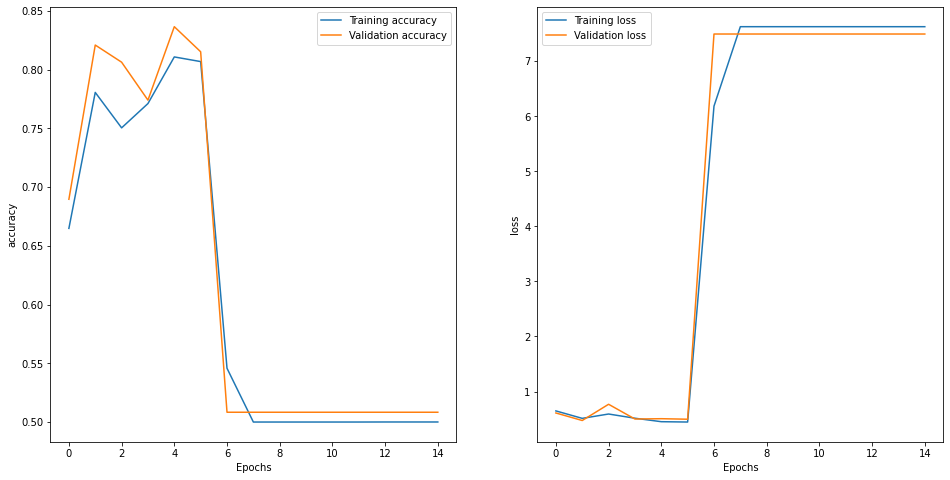

In [18]:
def plot_history(history, metric):  # 定义一个训练过程中绘制训练集和验证集关于metric变量的关系图，metric为accuracy或loss
    plt.plot(history.history[metric], label='Training ' + metric)
    plt.plot(history.history['val_'+metric], label='Validation ' + metric)
    plt.xlabel('Epochs')
    plt.ylabel(metric)
    plt.legend()

def check(model, history):
    test_loss, test_acc = model.evaluate(test)
    print('整个验证集的Loss: ', test_loss)
    print('整个验证集的Accuracy', test_acc)
    plt.figure(figsize=(16, 8))
    plt.subplot(1, 2, 1)
    plot_history(history, 'accuracy')
    plt.subplot(1, 2, 2)
    plot_history(history, 'loss')
    
check(model, history)

In [14]:
model1 = keras.Sequential([
    encoder,
    layers.Embedding(encoder.vocabulary_size(), 64, mask_zero=True),
    layers.Bidirectional(layers.LSTM(64)),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)
])
model1.compile(optimizer=tf.keras.optimizers.Adam(1e-4),  # 修改学习率（步长）为1e-4，默认为1e-3
              loss='binary_crossentropy',
              metrics=['accuracy'])
history1 = model1.fit(train, validation_data=test, epochs=15, validation_steps=30)  

Epoch 1/15
391/391 [==============================] - 31s 68ms/step - loss: 1.0446 - accuracy: 0.5296 - val_loss: 0.6753 - val_accuracy: 0.5828
Epoch 2/15
391/391 [==============================] - 25s 64ms/step - loss: 0.6525 - accuracy: 0.6372 - val_loss: 0.6063 - val_accuracy: 0.7188
Epoch 3/15
391/391 [==============================] - 25s 64ms/step - loss: 0.8156 - accuracy: 0.5110 - val_loss: 0.7050 - val_accuracy: 0.4990
Epoch 4/15
391/391 [==============================] - 25s 63ms/step - loss: 0.6443 - accuracy: 0.6018 - val_loss: 0.6076 - val_accuracy: 0.7068
Epoch 5/15
391/391 [==============================] - 25s 64ms/step - loss: 0.5872 - accuracy: 0.7279 - val_loss: 0.5646 - val_accuracy: 0.7411
Epoch 6/15
391/391 [==============================] - 25s 64ms/step - loss: 0.5412 - accuracy: 0.7604 - val_loss: 0.5164 - val_accuracy: 0.7557
Epoch 7/15
391/391 [==============================] - 25s 64ms/step - loss: 0.4897 - accuracy: 0.7879 - val_loss: 0.4887 - val_accuracy:

391/391 [==============================] - 10s 25ms/step - loss: 0.4853 - accuracy: 0.7890
整个验证集的Loss:  0.48529666662216187
整个验证集的Accuracy 0.7889999747276306


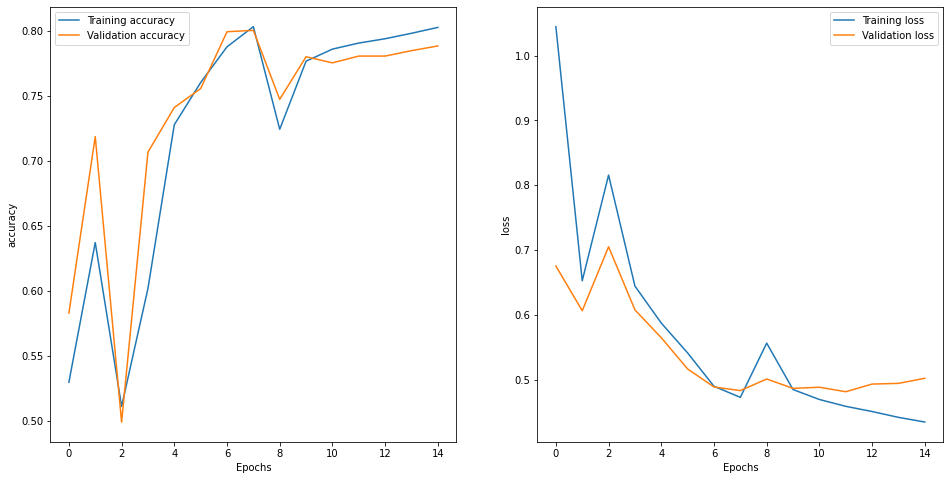

In [19]:
check(model1, history1)

波动还是很大，尝试进一步改进

In [16]:
model2 = keras.Sequential([
    encoder,
    layers.Embedding(encoder.vocabulary_size(), 64, mask_zero=True),
    layers.Bidirectional(layers.LSTM(64)),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)
])
model2.compile(optimizer=keras.optimizers.Adam(1e-4),  # 修改学习率（步长）为1e-4，默认为1e-3
              loss=keras.losses.BinaryCrossentropy(from_logits=True),  # 对输出值取logit
              metrics=['accuracy'])
history2 = model2.fit(train, validation_data=test, epochs=15, validation_steps=30)  

Epoch 1/15
391/391 [==============================] - 32s 68ms/step - loss: 0.6514 - accuracy: 0.5661 - val_loss: 0.5320 - val_accuracy: 0.7120
Epoch 2/15
391/391 [==============================] - 25s 64ms/step - loss: 0.4129 - accuracy: 0.8054 - val_loss: 0.3685 - val_accuracy: 0.8313
Epoch 3/15
391/391 [==============================] - 25s 64ms/step - loss: 0.3404 - accuracy: 0.8507 - val_loss: 0.3439 - val_accuracy: 0.8333
Epoch 4/15
391/391 [==============================] - 25s 64ms/step - loss: 0.3194 - accuracy: 0.8596 - val_loss: 0.3441 - val_accuracy: 0.8604
Epoch 5/15
391/391 [==============================] - 25s 64ms/step - loss: 0.3117 - accuracy: 0.8650 - val_loss: 0.3255 - val_accuracy: 0.8615
Epoch 6/15
391/391 [==============================] - 25s 64ms/step - loss: 0.3065 - accuracy: 0.8663 - val_loss: 0.3461 - val_accuracy: 0.8594
Epoch 7/15
391/391 [==============================] - 25s 63ms/step - loss: 0.3028 - accuracy: 0.8693 - val_loss: 0.3308 - val_accuracy:

391/391 [==============================] - 10s 25ms/step - loss: 0.3162 - accuracy: 0.8620
整个验证集的Loss:  0.31617119908332825
整个验证集的Accuracy 0.8619599938392639


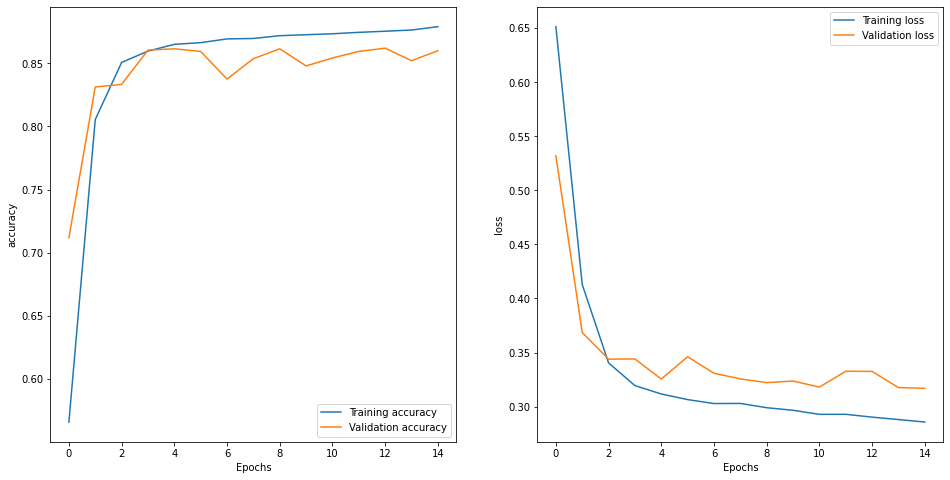

In [20]:
check(model2, history2)